# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- Define the problem ----

#### Data has been gathered from job listings containing the ideal candidate's required qualifications, some aspects of the position & company, along with the posted salary. The purpose of this notebook is to predict salaries of job listings with similar information which neglected to post a salary. The final product will consolidate the pre-pocessing, feature engineering, training, and predicting into a pipeline for production. The model should be constructed in less than 12 hours with the best accuracy possible, where mean-squared-error will be metric that the quality of the model is based upon. The end product may prove useful to recruiting firms and individual companies looking to remain competitive in the job market.

In [1]:
#Author name and contact information
__author__ = "Zachary Hoy"
__email__ = "hoyzach@gmail.com"

In [2]:
#Import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost
import pickle
%matplotlib inline

## Part 2 - DISCOVER

### ---- Load the data ----

In [3]:
#load the data into a Pandas dataframe
raw_train_features = pd.read_csv("data/train_features.csv")
raw_train_targets = pd.read_csv("data/train_salaries.csv")
raw_test_features = pd.read_csv("data/test_features.csv")

### ---- Clean the data ----

In [4]:
raw_train_features.shape

(1000000, 8)

In [5]:
raw_train_targets.shape

(1000000, 2)

In [6]:
#get a general overview of the training features provided
raw_train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [7]:
#get a general overview of the training targets provided
raw_train_targets.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [8]:
#get a general overview of the testing features provided
raw_test_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [9]:
#check to see if both jobId columns of training features and targets are in the same order
compare_jobIds = np.where(raw_train_features["jobId"] == raw_train_targets["jobId"],True,False)
np.unique(compare_jobIds, return_counts=False)

array([ True])

In [10]:
raw_train_targets.duplicated().sum()

0

In [11]:
#check for duplicate rows
raw_train_features.duplicated().sum()

0

In [12]:
#merge feature and target train data into single dataframe and drop jobId as its a duplicate index
df = pd.merge(raw_train_features, raw_train_targets, on='jobId')
df = df.drop('jobId',axis=1)
df.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [13]:
#delete the original files to save memory
del raw_train_features
del raw_train_targets
del raw_test_features

In [14]:
#check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   companyId            1000000 non-null  object
 1   jobType              1000000 non-null  object
 2   degree               1000000 non-null  object
 3   major                1000000 non-null  object
 4   industry             1000000 non-null  object
 5   yearsExperience      1000000 non-null  int64 
 6   milesFromMetropolis  1000000 non-null  int64 
 7   salary               1000000 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 68.7+ MB


In [15]:
#check for null values
df.isnull().any()

companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
salary                 False
dtype: bool

In [16]:
#check companyId column for invalid inputs
df['companyId'].unique()

array(['COMP37', 'COMP19', 'COMP52', 'COMP38', 'COMP7', 'COMP15',
       'COMP24', 'COMP20', 'COMP41', 'COMP56', 'COMP4', 'COMP54',
       'COMP57', 'COMP14', 'COMP61', 'COMP58', 'COMP3', 'COMP44',
       'COMP30', 'COMP27', 'COMP34', 'COMP11', 'COMP31', 'COMP49',
       'COMP0', 'COMP1', 'COMP36', 'COMP47', 'COMP8', 'COMP42', 'COMP50',
       'COMP53', 'COMP48', 'COMP45', 'COMP46', 'COMP2', 'COMP5', 'COMP55',
       'COMP29', 'COMP40', 'COMP33', 'COMP22', 'COMP12', 'COMP25',
       'COMP6', 'COMP23', 'COMP17', 'COMP28', 'COMP21', 'COMP26',
       'COMP43', 'COMP51', 'COMP10', 'COMP59', 'COMP13', 'COMP39',
       'COMP16', 'COMP9', 'COMP32', 'COMP62', 'COMP35', 'COMP18',
       'COMP60'], dtype=object)

In [17]:
#check jobType column for invalid inputs
df['jobType'].value_counts()

SENIOR            125886
VICE_PRESIDENT    125235
MANAGER           125121
CTO               125046
JANITOR           124971
CEO               124778
JUNIOR            124594
CFO               124369
Name: jobType, dtype: int64

In [18]:
#check degree column for invalid inputs
df['degree'].value_counts()

HIGH_SCHOOL    236976
NONE           236854
BACHELORS      175495
DOCTORAL       175364
MASTERS        175311
Name: degree, dtype: int64

In [19]:
#check major column for invalid inputs
df['major'].value_counts()

NONE           532355
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58596
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57801
Name: major, dtype: int64

In [20]:
#check industry column for invalid inputs
df['industry'].value_counts()

WEB          143206
AUTO         142943
FINANCE      142867
EDUCATION    142819
OIL          142771
HEALTH       142755
SERVICE      142639
Name: industry, dtype: int64

In [21]:
#check for negative or unrealistic values
df.describe()

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [22]:
#Explore the upper and lower quartiles of the target
dataset = df.salary.describe()
print(dataset)
IQR = dataset['75%']-dataset['25%']
upperlimit = dataset['75%'] + (1.5*IQR)
lowerlimit = dataset['25%'] - (1.5*IQR)
print("The upper outlier limit is", upperlimit)
print("The lower outlier limit is", lowerlimit)

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
The upper outlier limit is 220.5
The lower outlier limit is 8.5


In [23]:
#Explore the outliers at the lower end of the salary distribution
df.loc[df.salary < lowerlimit]

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


#### The lower limit outliers are $0 salaries. Since these targets do not contribute to the purpose of the model, its better to exclude them.

In [24]:
#Drop entries where posted salary = $0
df = df[df['salary'] > lowerlimit]
df.shape

(999995, 8)

In [25]:
#Explore the outliers at the upper end of the salary distribution
df.loc[df.salary > upperlimit,'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

#### Most positions with a salary above the upper limit are of high rank so they are acceptable, except for Junior positions which will be explored more.

In [26]:
#Explore the outliers at the upper end of the salary distribution where job level is listed as 'Junior'
df[(df.salary > upperlimit) & (df.jobType == 'JUNIOR')]

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427593,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


#### The majority of Junior positions require advanced degrees and are for jobs in the Oil and Finance industry. Since these are highly paid industry, these outliers are acceptable. 

### ---- Explore the data (EDA) ----

#### Summarize each variable and look for correlation between features & each feature and the target

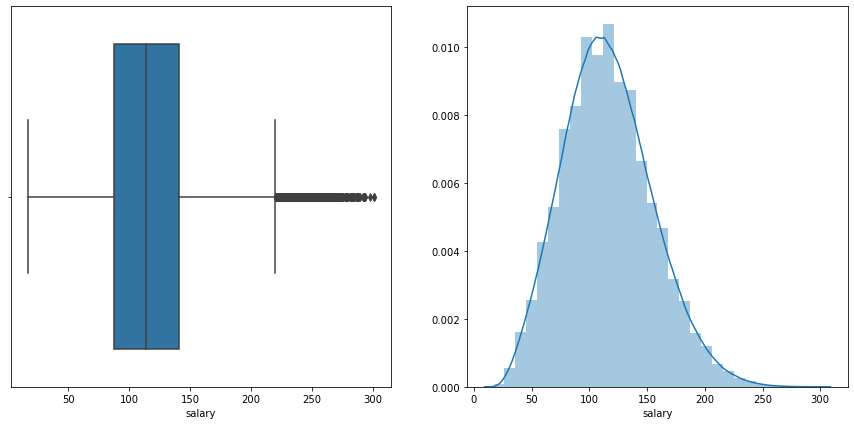

In [27]:
#Explore the target variable, salary
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.boxplot(df.salary)
plt.subplot(1,2,2)
sns.distplot(df.salary, bins=30)
plt.show()

In [28]:
#Eplore the feature variables
def plot_features(df,var): 
    '''
    produce plot for each features
    plot1(left), the distribution of samples on the feature
    plot2(right), the dependance of salary on the feature
    '''
    plt.figure(figsize = (14, 4))
    plt.subplot(1, 2, 1)
    if df[var].dtype == 'int64':
        df[var].value_counts().sort_index().plot()
    else:
        #change the object datatype of each variable to category type and order their level by the mean salary
        mean = df.groupby(var)["salary"].mean()
        df[var] = df[var].astype('category')
        level = mean.sort_values().index.tolist()
        df[var].cat.reorder_categories(level, inplace=True)
        df[var].value_counts().plot()        
    plt.xticks(rotation=45)
    plt.xlabel(var)
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)
    #There are many different companyIds so its better to visualize with a line graph
    if df[var].dtype == 'int64' or var == "companyId": 
        #Plot the mean salary for each category and shade the line between the (mean - std, mean + std)
        mean = df.groupby(var)["salary"].mean()
        std = df.groupby(var)["salary"].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values,alpha = 0.1)
    else:
        sns.boxplot(x= var, y="salary", data= df)
    
    plt.xticks(rotation=45)
    plt.ylabel('Salary')
    plt.show()

C:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
C:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


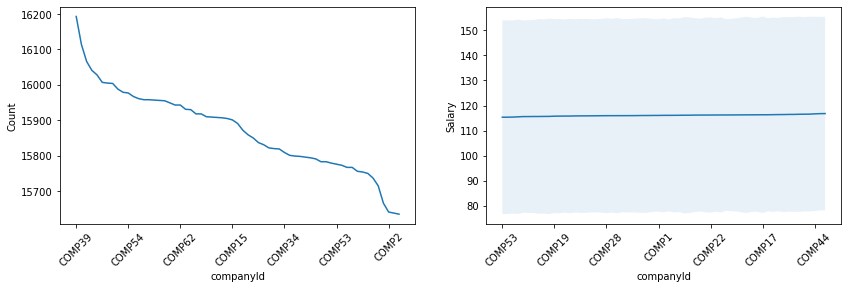

In [29]:
plot_features(df,"companyId")

C:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


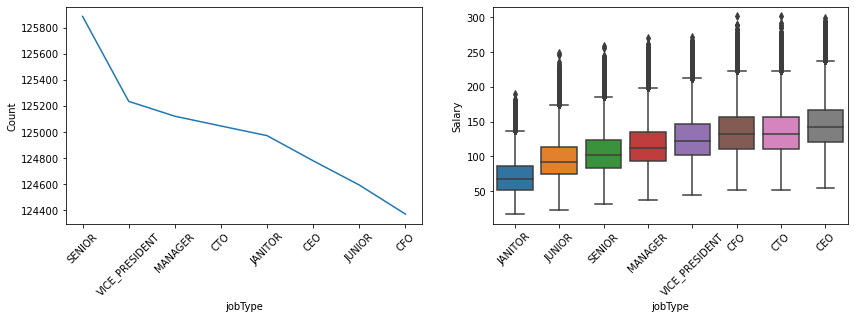

In [30]:
plot_features(df,"jobType")

C:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


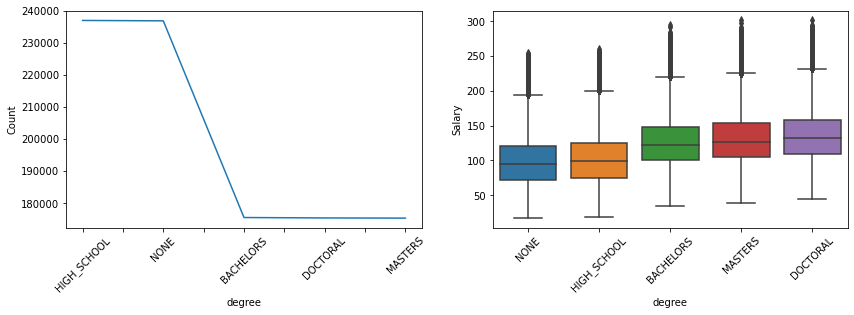

In [31]:
plot_features(df,"degree")

C:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


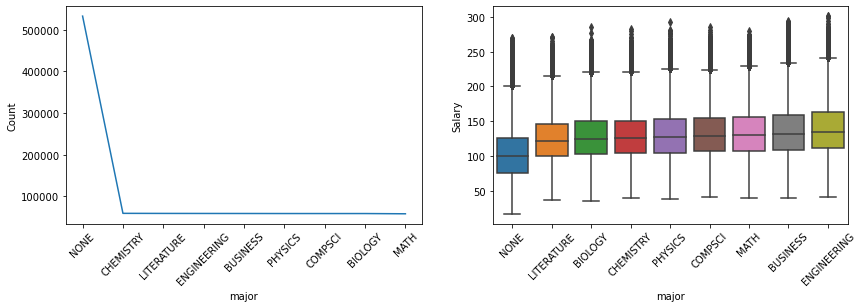

In [32]:
plot_features(df,"major")

C:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


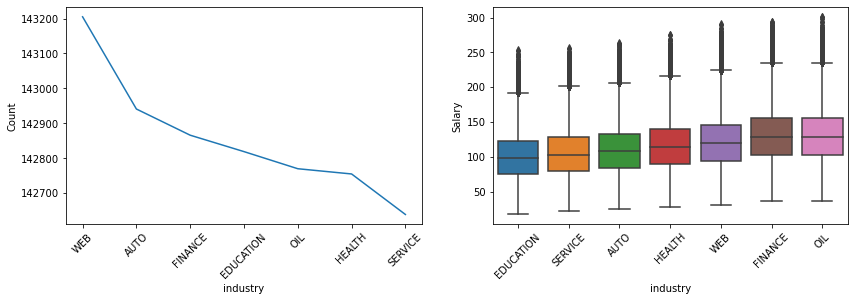

In [33]:
plot_features(df,"industry")

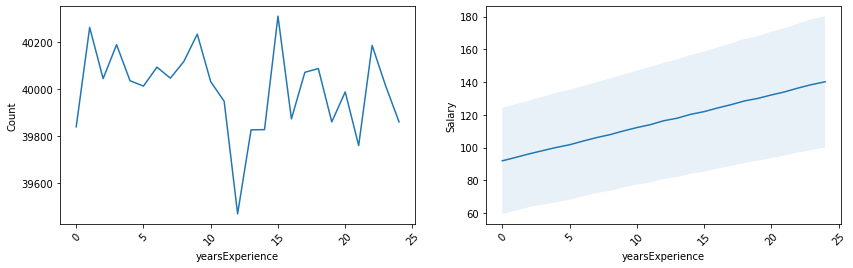

In [34]:
plot_features(df,"yearsExperience")

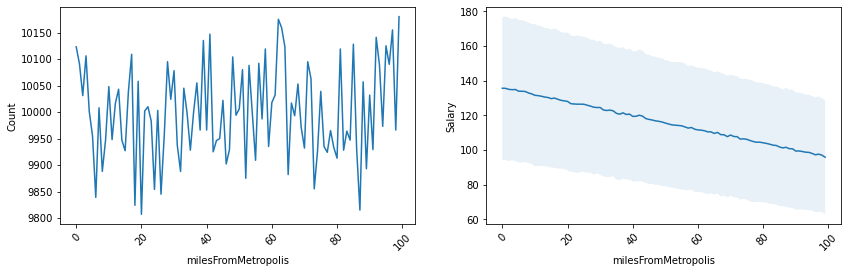

In [35]:
plot_features(df,"milesFromMetropolis")

In [36]:
#Function for encoding categorical data in a dataframe
def Encode_Data(df):    
    for col in df.columns:
        if df[col].dtype.name == 'category':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
    return df

In [37]:
#Create copy of dataframe and encode the categorical data
df_baseline = df.copy()
df_baseline = Encode_Data(df_baseline)

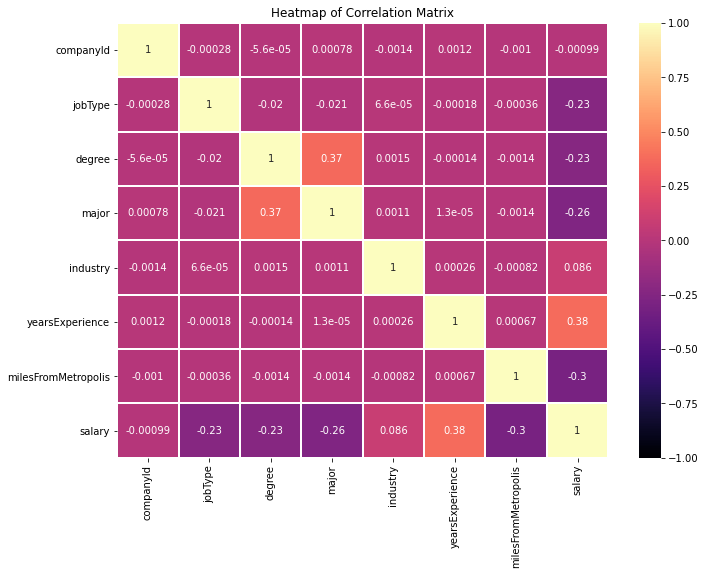

In [38]:
#Plot seaborn heatmap to visualize correlation between variables
plt.figure(figsize = (11,8))
corr = df_baseline.corr()
sns.heatmap(corr,
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values,cmap = "magma", vmin=-1, vmax=1,annot=True, linewidths=1)
plt.title('Heatmap of Correlation Matrix')
plt.show()

#### Upon analyzation of the above graphs and heatmap, it looks like years experience and miles from metropolis are the features most correlated with salary. There are also no signs of collinearity between existing features. Company ID has almost zero correlation with salary and its removal from the final training set will be considered, but for now it will be included in the baseline model.

### ---- Establish a baseline ----

#### Build a simple baseline model to track improvements.

In [39]:
#return feature column names
df_baseline.columns

Index(['companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis', 'salary'],
      dtype='object')

In [40]:
#split features and targets into two separate dataframes
df_features_baseline = df_baseline[['companyId','jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis']]
df_targets_baseline = df_baseline[['salary']]
del df_baseline

In [41]:
#fit a very basic linear model and calculate its MSE
lr = LinearRegression()
lr_baseline_mse = cross_val_score(lr, df_features_baseline, df_targets_baseline, scoring = 'neg_mean_squared_error')
lr_baseline_mse = -1*lr_baseline_mse.mean()
print("Baseline MSE Score: ", lr_baseline_mse)

Baseline MSE Score:  925.1195135463097


#### Additional models, hyperparameter tuning, and feature engineering will be utilized to reduce this baseline MSE, of about 925, to roughly one-third of this value.

### ---- Hypothesize solution ----

#### Models expected to return better accuracy than the baseline linear model:
- Stochastic Gradient Descent - Works well we large number of observations (<100K), may show improvement of linear regressor.
- Decision Tree - Worth the effort as this algorithm is relatively simple and very popular.
- Random Forest - If moving forward with one-hot encoding and creating more variables, this algorithm could provide higher accuracy over decision tree
- Xgboost - This algorithm can optimize on least squares regression with a low probability of overfitting.

#### Feature engineering explored in an effort to achieve a better accuracy over the baseline linear model:
- Both ordinal encoding and one hot encoding were explored. They both resulted in a better mse score, but one hot encoding was superior. One hot encoding of the categorical features and min-max scaling of the continuous features (for SGD model) will be utilized.
- Changing observations with degree != 'NONE' and major = 'NONE' to major = 'ANY' in order to distinguish between no degree / no major and degree / no major. This did not result in a better mse score.
- Binning together degree = 'NONE' and degree = 'HIGH_SCHOOL'. This did not result in a better mse score.
- Binning years experience and miles from metropolis. This did not result in a better mse score.

## Part 3 - DEVELOP

### ----  Engineer features  ----

In [42]:
#Separate categorical features into a separate dataframe for one hot encoding - excluding company ID from the model
df_categories = df[['jobType', 'degree', 'major', 'industry']]
df_categories = pd.get_dummies(df_categories,drop_first=True)

In [43]:
df_categories.shape

(999995, 25)

In [44]:
df_continuous = df[['yearsExperience','milesFromMetropolis']]
cols = df_continuous.columns
df_continuous = MinMaxScaler().fit_transform(df_continuous)
df_continuous = pd.DataFrame(df_continuous, columns = cols)

In [45]:
#Combine categorical features and numerical features
df_features = pd.concat([df_categories.reset_index(drop=True),df_continuous],axis=1)
df_targets = df[['salary']]
del df_categories, df_continuous

In [46]:
df_features.shape

(999995, 27)

### ---- Create, test and select best model ----

In [47]:
#Function for determining the 5F-CV MSE of each individual model
def evaluate_model(model):
    neg_mse = cross_val_score(model,df_features,df_targets.values.ravel(),scoring='neg_mean_squared_error')
    mse = -1 * neg_mse
    std_mse = mse.std()
    mean_mse = mse.mean()
    print("\nModel:\n",model)
    print("    Standard Deviation of Cross Validation MSEs:\n    ", std_mse)
    print("    Mean 5-Fold Cross Validation MSE:\n    ", mean_mse)
    return mean_mse

In [48]:
#loop through different models and obtain each corresponding mse. Hyperparameters have been chosen through manual testing.
models = []
mean_mse = {}

lr = LinearRegression()

sgd = SGDRegressor(max_iter = 200, learning_rate = 'optimal')

dtr = DecisionTreeRegressor(max_depth = 15)

rf = RandomForestRegressor(n_estimators = 150, n_jobs = -1, max_depth = 30, min_samples_split = 60, max_features = 'sqrt')

xgb = xgboost.XGBRegressor(max_depth = 4, n_estimators = 200, learning_rate = 0.2, objective = 'reg:squarederror')

models.extend([lr,sgd,dtr,rf,xgb])

print("Starting Cross Validation of Models...\n")

for model in models:
    mse_iter = evaluate_model(model)
    mean_mse.update({model:mse_iter})
    
best_model = min(mean_mse,key=mean_mse.get)
    
print("\n\nThe model with the lowest average MSE to use for predictions is:\n")
print(best_model)

Starting Cross Validation of Models...


Model:
 LinearRegression()
    Standard Deviation of Cross Validation MSEs:
     1.782017930828889
    Mean 5-Fold Cross Validation MSE:
     384.4143373223812

Model:
 SGDRegressor(learning_rate='optimal', max_iter=200)
    Standard Deviation of Cross Validation MSEs:
     1.853858817502083
    Mean 5-Fold Cross Validation MSE:
     384.5534589184883

Model:
 DecisionTreeRegressor(max_depth=15)
    Standard Deviation of Cross Validation MSEs:
     2.011612370327358
    Mean 5-Fold Cross Validation MSE:
     433.1285879321754

Model:
 RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=60,
                      n_estimators=150, n_jobs=-1)
    Standard Deviation of Cross Validation MSEs:
     1.7064529553217143
    Mean 5-Fold Cross Validation MSE:
     372.09158913196814

Model:
 XGBRegressor(learning_rate=0.2, max_depth=4, n_estimators=200,
             objective='reg:squarederror')
    Standard Deviation of Cross Valida

### ---- Fine-tune best model ----

In [49]:
#split training data into training and testing dataframes for use in grid search function
X_train, X_test, y_train, y_test = train_test_split(df_features, df_targets, random_state=36, test_size=0.2)

In [50]:
# Create empty array to store results
results = []

# Create watchlist to keep track of train/validation performance
eval_set = [(X_train, y_train), (X_test, y_test)]

In [51]:
# Enumerate through different max_depth values and store results
for max_depth in [2,3,4,5,10,12,15]:
    clf = xgboost.XGBRegressor(max_depth = max_depth, learning_rate = 0.2, n_estimators = 200, objective = 'reg:squarederror')
    clf.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    results.append(
        {
            'max_depth': max_depth,
            'train_error': metrics.mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': metrics.mean_squared_error(y_test, clf.predict(X_test))
        })
    
# Display Results
max_depth_lr = pd.DataFrame(results).set_index('max_depth').sort_index()
max_depth_lr

,train_error,test_error
max_depth,,
2,374.610929,372.236977
3,362.998304,361.491560
4,358.359948,357.305873
5,355.386789,356.404752
10,293.085752,369.157290
12,229.962078,388.669582
15,134.964527,434.130734


<AxesSubplot:title={'center':'Max_Depth Learning Curve'}, xlabel='max_depth'>

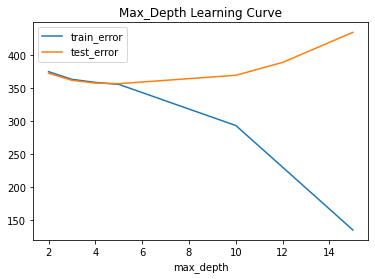

In [52]:
# Plot Max_Depth Learning Curve
max_depth_lr.plot(title="Max_Depth Learning Curve")

#### It looks like the optimal max_depth value is around 4 or 5. We will continue further testing with a value of 4 as max_depth for boosting trees should not exceed this value.

In [53]:
# Reset results array
results = []

# Enumerate through different learning_rate values and store results
for learning_rate in [0.05,0.1,0.2,0.4,0.6,0.8,1]:
    clf = xgboost.XGBRegressor(max_depth = 4, learning_rate = learning_rate, n_estimators=200, objective = 'reg:squarederror')
    clf.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    results.append(
        {
            'learning_rate': learning_rate,
            'train_error': metrics.mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': metrics.mean_squared_error(y_test, clf.predict(X_test))
        })
    
# Display Results    
learning_rate_lr = pd.DataFrame(results).set_index('learning_rate').sort_index()
learning_rate_lr

,train_error,test_error
learning_rate,,
0.05,393.880518,392.140931
0.10,363.194764,361.760581
0.20,358.359948,357.305873
0.40,355.616075,355.766613
0.60,354.489195,355.496813
0.80,354.011545,355.716576
1.00,353.620244,355.841460


<AxesSubplot:title={'center':'Learning Rate Learning Curve'}, xlabel='learning_rate'>

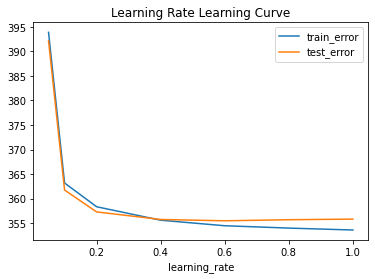

In [54]:
#Plot Learning Rate Learning Curve
learning_rate_lr.plot(title="Learning Rate Learning Curve")

#### It looks like the optimal learning_rate value is between 0.3 and 0.5. Further testing will continue with these values.

In [55]:
# Reset results array
results = []

# Enumerate through different n_estimators values and store results
for n_estimators in [50,60,100,150,200,500,750,1000, 1500]:
    clf = xgboost.XGBRegressor(max_depth = 4, learning_rate = 0.2, n_estimators = n_estimators, objective = 'reg:squarederror')
    clf.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    results.append(
        {
            'n_estimators': n_estimators,
            'train_error': metrics.mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': metrics.mean_squared_error(y_test, clf.predict(X_test))
        })

# Display Results
n_estimators_lr = pd.DataFrame(results).set_index('n_estimators').sort_index()
n_estimators_lr

,train_error,test_error
n_estimators,,
50,394.573583,392.593612
60,383.407842,381.512851
100,365.557936,364.027336
150,360.515351,359.195003
200,358.359948,357.305873
500,354.247736,354.882259
750,352.762697,354.413865
1000,351.692722,354.313764
1500,350.093521,354.299623


<AxesSubplot:title={'center':'N_Estimators Learning Curve'}, xlabel='n_estimators'>

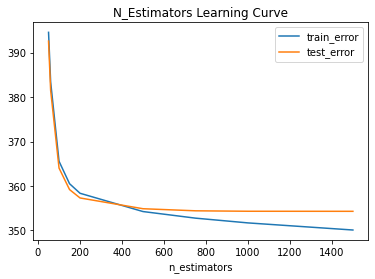

In [56]:
#Plot N_Estimators Rate Learning Curve
n_estimators_lr.plot(title="N_Estimators Learning Curve")

#### It looks like the optimal n_estimators value is around 500.

In [57]:
# Define Parameters for Grid Search function
param_grid = {"max_depth": [2,3,4],
              "max_features" : [1.0,0.5,0.1],
              "min_samples_leaf" : [2,3,5],
              "n_estimators": [300,500,600],
              "learning_rate": [0.3,0.4,0.5]}

# Initialize model parameter
model = xgboost.XGBRegressor()

In [58]:
# Perform Grid Search CV
gs_cv = GridSearchCV(model, param_grid=param_grid, cv = 3, verbose=10, n_jobs=-1 ).fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 42.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 54.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 66.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 80.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 93.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 115.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 143.0min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 167.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 192.1min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 220.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapse

[15:43:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [59]:
# Return best hyperparameter setting
gs_cv.best_estimator_

XGBRegressor(learning_rate=0.4, max_features=1.0, min_samples_leaf=2,
             n_estimators=600)

In [60]:
# Save best hyperparameter setting
best_model = gs_cv.best_estimator_

In [62]:
# Run model too see improvement of MSE
evaluate_model(best_model)

[15:56:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:02:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:09:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:23:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model:
 XGBRegressor(learning_rate=0.4, max_features=1.0, min_samples_leaf=2,
             n_estimators=600)
    Standard Deviation of Cross Validation MSEs:
     1.2898810285173057
    Mean 5-Fold Cross Validation MSE:
     355.7364235391319


355.7364235391319

#### The model has not improved by much, but these hyperparameters will still be utilized for deployment.

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [63]:
#Script that trains model on entire training set and saves model to disk
def load_clean_model_data(raw_train_features, raw_train_targets):
    
    #load csv files
    df_features = pd.read_csv(raw_train_features)
    df_targets = pd.read_csv(raw_train_targets) 

    #clean feature and target dataframes per analysis above
    df = pd.merge(df_features,df_targets, on='jobId')
    df = df[df['salary'] > 0]
    df_categories = df[['jobType', 'degree', 'major', 'industry']]
    df_categories = pd.get_dummies(df_categories,drop_first=True)
    df_features = pd.concat([df_categories,df[['yearsExperience','milesFromMetropolis']]],axis=1)
    df_targets = df[['salary']]
    del df_categories, df
    
    #implement best model discovered per analysis above
    model = xgboost.XGBRegressor(learning_rate=0.4, max_features=1.0, min_samples_leaf=2,
             n_estimators=600, objective = 'reg:squarederror')
    model.fit(df_features,df_targets)
    
    #save model to disk
    filename = 'salary_prediction.sav'
    pickle.dump(model, open(filename,'wb'))
    
    #informs user that process is complete
    print("Data prepraration and model creation complete.")
    
    return filename

#Script that prepares data, predicts salaries, and exports results
def export_results(raw_test_features, filename):

    #load csv file
    df_pred_features = pd.read_csv(raw_test_features)
    
    #saves jobId column for output file
    df_pred_jobId = pd.DataFrame(df_pred_features['jobId'])
    
    #prepares data to be fed into the model
    df_pred_categories = df_pred_features[['jobType', 'degree', 'major', 'industry']]
    df_pred_categories = pd.get_dummies(df_pred_categories,drop_first=True)
    df_pred_features = pd.concat([df_pred_categories,df_pred_features[['yearsExperience','milesFromMetropolis']]],axis=1)
    del df_pred_categories
    
    #loads model from disk, predicts salaries, and exports results to .csv file
    loaded_model = pickle.load(open(filename, 'rb'))
    df_pred = pd.DataFrame(loaded_model.predict(df_pred_features))
    df_pred.columns = ['salary']
    df_pred = pd.concat([df_pred_jobId,df_pred],axis=1)
    df_pred.to_csv('predicted_salaries.csv')
    
    #plot feature importance of model and save figure to .jpg file
    fig, ax = plt.subplots(figsize=(12,8))
    xgboost.plot_importance(loaded_model, height=0.6, ax=ax)
    fig.savefig('feature_importance.jpg')
    
    #informs user that process is complete
    print("Predictions exported to .csv file.","\nFeature importances exported to .jpg file.")

### ---- 12 Deploy solution ----

In [64]:
filename = load_clean_model_data("data/train_features.csv","data/train_salaries.csv")

Data prepraration and model creation complete.


Predictions exported to .csv file. 
Feature importances exported to .jpg file.


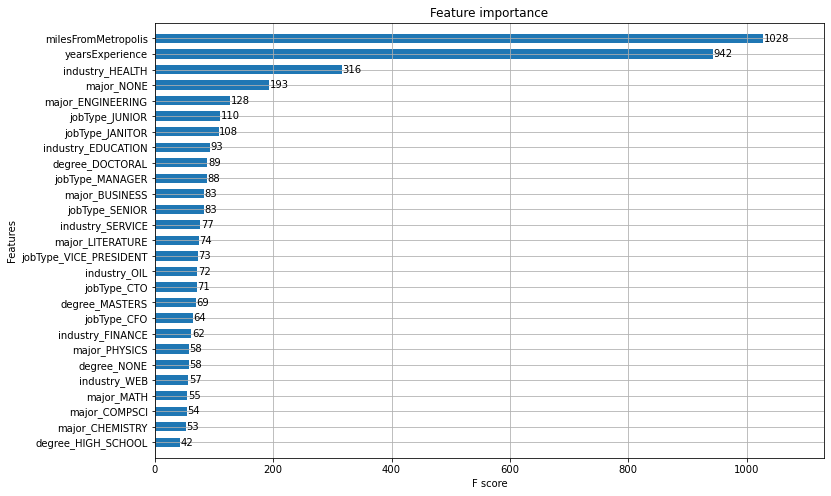

In [65]:
export_results("data/test_features.csv",filename)